In [1]:
import numpy as np
import pandas as pd
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed

import anndata

from scipy.stats import pearsonr, ranksums

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
indir = 'dataset/domain/'
res = 25000

In [3]:
# sc_border = anndata.read_h5ad(f'cell_900_boundary.h5ad')
# sc_border

In [4]:
def compute_domain_size(i):
    global res, sc_border
    tmp = sc_border.raw.X[i]
    tmp = np.repeat(tmp.indices, tmp.data).reshape((-1, 2))
    return (tmp[:, 1] - tmp[:, 0]).sum() * res

In [5]:
meta_file = '/data/metadata/240104_m3C_META.csv'
metadata = pd.read_csv(meta_file, index_col = 0)
metadata['AgingMajorType'] = metadata['AgingMajorType'].apply(lambda x: x.replace(' ','_').replace('/',''))
metadata = metadata[['AgingMajorType','Age','Replicate']]

In [6]:
metadata= metadata.loc[sc_border.obs_names]

NameError: name 'sc_border' is not defined

In [14]:
ncpu = 20
domain_size, cell_list = [], []
with ProcessPoolExecutor(ncpu) as exe:
    future_dict = {}
    for i,cell in enumerate(metadata.index):
        future = exe.submit(compute_domain_size, i=i)
        future_dict[future] = cell

    for future in as_completed(future_dict):
        cell = future_dict[future]
        # print(f'{cell} finished.')
        domain_size.append(future.result())
        cell_list.append(cell)

In [15]:
domain_size = pd.Series(domain_size, index=cell_list)
metadata['domain_coverage'] = domain_size.copy()
metadata.loc[sc_border.obs.index, 'domain_count'] = sc_border.raw.X.sum(axis=1).A1 / 2

In [17]:
# sc_border.X.data = np.ones(sc_border.X.data.shape)
metadata.loc[sc_border.obs.index, 'boundary_count'] = sc_border.raw.X.getnnz(axis=1)

In [33]:
metadata['domain_size'] = metadata['domain_coverage'] / metadata['domain_count']

In [18]:
metadata['AgingMajorType.Age'] = metadata['AgingMajorType'].astype(str) + '.' + metadata['Age'].astype(str)

In [21]:
leg = ['Oligo_NN.8wk', 'Oligo_NN.9mo', 'Oligo_NN.18mo']

In [25]:
from amb import *
age_dict = get_age_palette()
age_dict['8wk'] = age_dict['2mo']

In [36]:
legname = 'Age'

In [37]:
group_dict = {'Oligo_NN.8wk':age_dict['8wk'], 
              'Oligo_NN.9mo':age_dict['9mo'], 
              'Oligo_NN.18mo':age_dict['18mo']}

In [44]:
metadata.loc[~metadata['Age'].isin(['8wk']), 'domain_count']

AMB_220609_9mo_8E_9H_I8J_9J_2_P3-6-O5-N12     2798.0
AMB_220609_9mo_13D_14C_2_P3-3-A11-O6          3751.0
AMB_220609_9mo_13D_14C_2_P3-1-A11-J2          3500.0
AMB_220609_9mo_8E_9H_I8J_9J_2_P2-1-E5-P13     2014.0
AMB_220517_9mo_5E_6E_1_P3-6-L3-G23            2831.0
                                               ...  
AMB_220630_18mo_13D_14C_1_P2-3-I2-M17         2468.0
AMB_220714_18mo_11E_11F_12E_2_P2-6-M17-M24    3355.0
AMB_220707_18mo_2A_3A_1_P1-1-I3-P13           2235.0
AMB_220712_18mo_7H_8H_9G_2_P2-6-E5-L11        3156.0
AMB_220616_18mo_12D_13B_1_P3-4-C10-M7         2543.0
Name: domain_count, Length: 600, dtype: float64

In [46]:
ranksums(metadata.loc[metadata['Age'].isin(['8wk']), 'domain_count'], 
         metadata.loc[metadata['Age'].isin(['18mo']), 'domain_count'])

RanksumsResult(statistic=-1.9000631101408252, pvalue=0.05742483808191474)

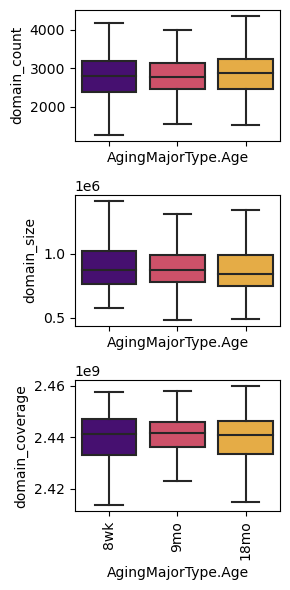

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(3,6), sharex='all', dpi=100)
ax = axes[0]
sns.boxplot(data=metadata, x='AgingMajorType.Age', y='domain_count', order=leg, showfliers=False, palette=group_dict, ax=ax)
ax = axes[1]
sns.boxplot(data=metadata, x='AgingMajorType.Age', y='domain_size', order=leg, showfliers=False, palette=group_dict, ax=ax)
ax = axes[2]
sns.boxplot(data=metadata, x='AgingMajorType.Age', y='domain_coverage', order=leg, showfliers=False, palette=group_dict, ax=ax)
ax.set_xticklabels(['8wk','9mo','18mo'],rotation=90)
plt.tight_layout()
# plt.savefig(f'cell_{sc_border.shape[0]}_majortype_domain_boxplot.pdf', transparent=True, dpi=300)